In [1]:
import dicom
import glob
import os
import matplotlib.pyplot as plt

image_files = glob.glob('./sample_images/*/*.dcm')
# print(image_files)
# plans = [dicom.read_file(i) for i in image_files[:256]]
# plan = dicom.read_file(image_files[0])
# print(plan.keys())

In [2]:
INPUT_FOLDER = './sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [3]:
# Load the scans in given folder path
import numpy as np

def load_scan(path):
    slices = [dicom.read_file(s) for s in glob.glob(path + '/*.dcm')]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [4]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

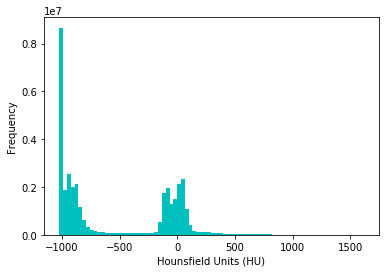

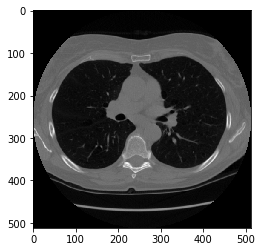

In [5]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [6]:
import scipy.ndimage

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [7]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (335, 306, 306)


In [8]:
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [71]:
def plot_slices(image, vmin, vmax):
    img_size = image.shape[1]
    nb_slices = image.shape[0]
    row_size = 3
    nb_rows = int(nb_slices / row_size)
    # dpi=size of the image will render a single image of figsize(1,1) at the full pixel resolution
    # subplot 
    fig, axes = plt.subplots(nb_rows, 
                             row_size, 
                             dpi=img_size, 
                             figsize=(row_size, nb_rows)
                            )

    # plt.imshow(plan.pixel_array, cmap="nipy_spectral")
    for i, ax in enumerate(axes.flat):
        ax.imshow(image[i], cmap='nipy_spectral', vmin=vmin, vmax=vmax)
    #     ax.set_title(image_files[i])
        ax.axis('off')
        
    plt.axis('off')
    plt.show()

In [22]:
def plot_histograms(image):
    fig, axes = plt.subplots(66, 5, figsize=(20,264))
    for i, ax in enumerate(axes.flat):
        ax.hist(image[i].flatten(), bins=128, color='c')
        #ax.axis('off')
        
    plt.axis('off')
    plt.show()

In [11]:
# show bones
# plot_3d(pix_resampled, 400)

In [73]:
from skimage.morphology import square
from skimage.morphology import dilation

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1 - binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
        
    # adding dilation/expansion of the binary mask by 1 pixels here
    for i, axial_slice in enumerate(binary_image):
        binary_image[i] = dilation(binary_image[i], square(3))
 
    return binary_image

In [32]:
# labels = measure.label(binary_image)
# plot_slices(labels, 0, 1)

In [30]:
# background_label = labels[0,0,0]
# binary_image[background_label == labels] = 2
# plot_slices(binary_image, 0, 1)

In [31]:
# binary_image -= 1 #Make the image actual binary
# binary_image = 1 - binary_image # Invert it, lungs are now 1
# plot_slices(binary_image, 0, 1)

In [56]:
#segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

In [34]:
# plt.hist(segmented_lungs_fill.flatten(), bins=8, color='c')
# plt.xlabel("value")
# plt.ylabel("Frequency")
# plt.show()

In [74]:
mask = segmented_lungs_fill
masked_image = np.multiply(pix_resampled, mask) # effectively multiply by the mask element-wise 

In [75]:
#pix_resampled[pix_resampled < -302] = 0
# plt.hist(masked_image.flatten(), bins=128, color='c')
# plt.xlabel("value")
# plt.ylabel("Frequency")
# plt.show()


In [76]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [77]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [78]:
normed_lungs = normalize(masked_image)

In [79]:
# plt.hist(normed_lungs[101].flatten(), bins=128, color='c')
# plt.xlabel("value")
# plt.ylabel("Frequency")
# plt.show()


In [80]:
centered_lungs = zero_center(normed_lungs)

In [81]:
# plt.hist(centered_lungs[102].flatten(), bins=128, color='c')
# plt.xlabel("value")
# plt.ylabel("Frequency")
# plt.show()


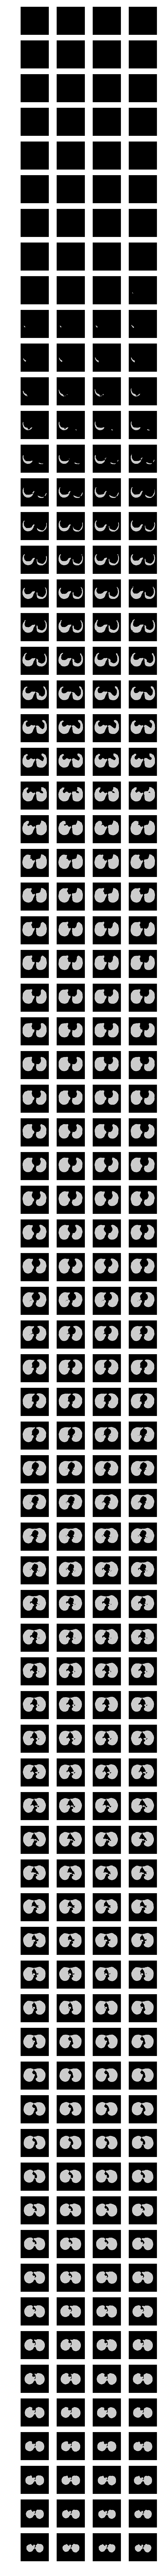

In [70]:
# plot the mask images (0,1)
plot_slices(mask, 0, 1)

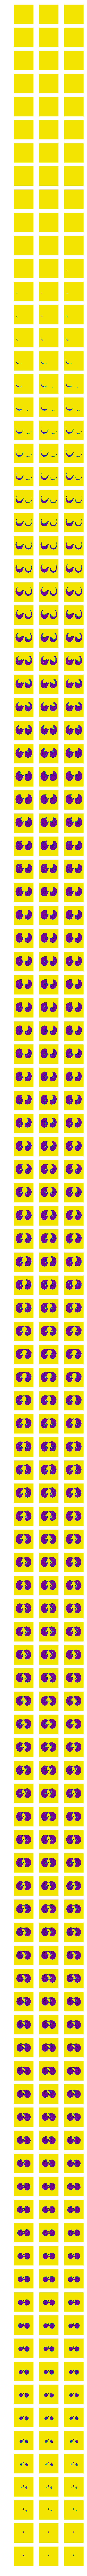

In [82]:
# plot slices masked, normalized and centered offset by 0.25
plot_slices(centered_lungs, -.25, 0.75)

In [ ]:
#plot_3d(centered_lungs, -0.17)

In [29]:
#plot_histograms(centered_lungs)